In [31]:
#import required libs
import torch
import torch.nn
from torch.autograd.gradcheck import zero_gradients
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import copy
import json
%matplotlib inline

### Image Pre-processing

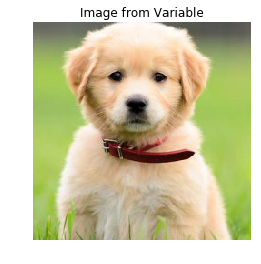

In [85]:
# Loads image from filename, 
# Resizes it to indicated size 
# Normalizes the image as vgg19 was trained on normalized images
# Converts it into a Variable whose gradient can be taken
# Also adds a fake batch dimension to image, making it ready to be inputted into vgg19
def load_image(filename, size):
    image = Image.open(filename)
    loader = transforms.Compose([
        transforms.Resize((240,240)),  
        transforms.ToTensor()
    ])
    
    image_tensor = loader(image).unsqueeze(0)
    mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406])).view(-1, 1, 1)
    std = torch.tensor(torch.tensor([0.229, 0.224, 0.225])).view(-1, 1, 1)
    image_tensor_normalized = (image_tensor - mean) / std
    
    image_variable = Variable(image_tensor_normalized, requires_grad=True)
    assert(image_variable.size() == torch.Size([1, 3, 240, 240]))
    
    return image_variable


# Grab image, need it to be 240x240
image_var = load_image("./images/dog.jpg", (240,240))


# Displays the image from its tensor (think modified image tensor, after adding epsilon noise)
def show_image(tensor, title=None, save=False, save_name=None):
    image = tensor.clone()        # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    
    mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406])).view(-1, 1, 1)
    std = torch.tensor(torch.tensor([0.229, 0.224, 0.225])).view(-1, 1, 1)
    image_tensor_unnormalized = (image * std) + mean
    
    unloader = transforms.ToPILImage()
    image_final = unloader(image_tensor_unnormalized)
    
    plt.figure()
    plt.axis('off')
    plt.imshow(image_final)
    
    if title is not None:
        plt.title(title)
        
    if save:
        plt.savefig(save_name)
        
    return


show_image(image_var.data, title='Image from Variable')

### Model: VGG19 (State-of-the-art, pre-trained)
Needs images resized to 240x240

In [33]:
cnn = models.vgg19(pretrained=True).eval()

### Classifying image and showing top 10 classes

In [34]:
# Let's try classifying the image
image_trial = load_image("./dog.jpg", (240,240))
output = cnn(image_trial)

# Prints the top k classes with the confidence levels from the out=model(image) variable
def top_k(out, k=10):
    # Get most probable class
    label_idx = torch.max(out.data, 1)[1][0]

    # Have an output tensor of classes and values per class
    # Need a mapping from class indices to class names
    with open('imagenet_class_index.json') as f: class_idx = json.load(f)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

    # Get top 10 labels
    labels = [idx2label[idx] for idx in out[0].sort()[1][-k:]]
    labels.reverse()

    # Also need to pass the tensor to softmax for probability dist on classes for confidence level
    confidences = F.softmax(out, dim=1)

    # Get top 10 confidences
    confidences = list(np.asarray(confidences.data.sort()[0][0]))
    confidences.reverse()

    for i in range(k):
        print(labels[i], confidences[i]*100, '%')
        
    return

top_k(output)

golden_retriever 96.53496146202087 %
Labrador_retriever 2.170245535671711 %
tennis_ball 0.3255081130191684 %
kuvasz 0.1784397754818201 %
soccer_ball 0.17493321793153882 %
Great_Pyrenees 0.11685092467814684 %
clumber 0.10115603217855096 %
Border_collie 0.06372759817168117 %
Sussex_spaniel 0.056562724057585 %
Brittany_spaniel 0.04760420706588775 %


### Add perturbations to get another class with 99% accuracy
We use FGSM, find perturbations which increase the loss for the true class subsequently leading to misclassification. Also, FGSM is a non-targeted method. We can easily convert it into targeted method by maximizing probability $P(Y_{target}|X)$ for some target class $Y_{target}$ and input image $X$. 

For a neural network with cross-entropy loss $J(X,Y)$, the formula will be:
$$X_{adversarial}=X_{input}− \epsilon \cdot \text{sign}(\nabla_X J(X, Y_{target})$$
 
Instead of adding perturbation to the original input, we need to remove it from the original input. 

We build this mechanism such that we can target any desired class. We need to iterate a number of times to max out the confidence level on the target class. 

In [392]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([153]), requires_grad=False) #283= cat 153=dog

# Max change per pixel
epsilon = 0.5

# Max iterations
num_steps = 25

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting image 
image_start = load_image("./images/cat_5.jpg", (240,240))

# This tensor stays fixed for reference point
image_tensor = image_start.data

for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output = cnn.forward(image_start)
    loss_value = loss(output, y_target)
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad = alpha * torch.sign(image_start.grad.data)

    # k pixels thick border
#     k=10
#     grad[:, :, k:-k, k:-k] = 0
    
    image_temp = image_start.data - grad
    total_grad = image_temp - image_tensor
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    image_adversarial = image_tensor + total_grad
    image_start.data = image_adversarial
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


Maltese_dog 99.92579221725464 %
Lhasa 0.02722062636166811 %
Shih-Tzu 0.015830401389393955 %
Pekinese 0.006481652962975204 %
mosquito_net 0.0058914622059091926 %
toy_poodle 0.005669823076459579 %
Japanese_spaniel 0.001543649887025822 %
Yorkshire_terrier 0.001523633090982912 %
West_Highland_white_terrier 0.0008691547918715514 %
bassinet 0.0008254899512394331 %


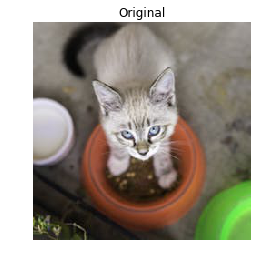

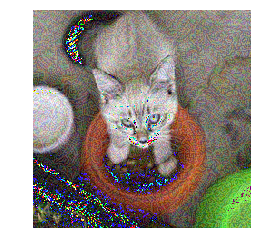

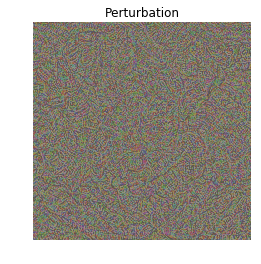

In [393]:
top_k(cnn(image_start))

show_image(image_tensor, title='Original')
show_image(image_start, title=None, save=True, save_name='cat_6.jpg')
show_image(image_start.data - image_tensor, title='Perturbation')

torchvision.utils.save_image(image_start.data, 'lolol.jpg')

Original:
Egyptian_cat 34.12944972515106 %
After Perturbation:
Egyptian_cat 28.26434075832367 %
Egyptian_cat 28.26434075832367 %
tabby 27.15957760810852 %
lynx 10.879325866699219 %
tiger_cat 7.8000277280807495 %
Siamese_cat 6.20785690844059 %
remote_control 4.867623746395111 %
carton 2.2202344611287117 %
bow_tie 1.8436992540955544 %
paper_towel 1.3553833588957787 %
plastic_bag 1.1773765087127686 %


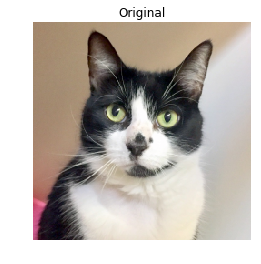

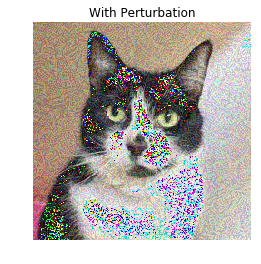

In [395]:
perturbation = image_start - image_tensor
image_plus_perturbation('./images/cat_3.jpg', perturbation, draw=True)
top_k(cnn(perturbation + load_image('./images/cat_3.jpg', (240,240))))

Original:
goose 37.99434304237366 %
After Perturbation:
golden_retriever 96.53496742248535 %


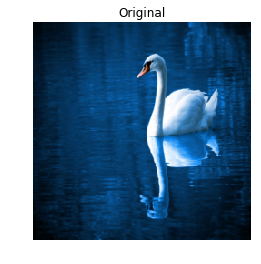

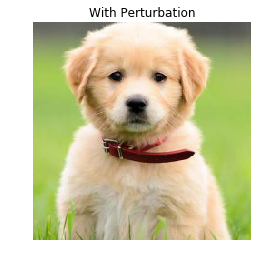

In [35]:
def image_plus_perturbation(image_name, perturbation, draw=True):
    image = load_image(image_name, (240,240))
    print('Original:')
    top_k(cnn(image), 1)
    
    image_w_perturbation = image + perturbation
    print('After Perturbation:')
    top_k(cnn(image_w_perturbation), 1)    
    
    if draw:
        show_image(image, title='Original')
        show_image(image_w_perturbation, title='With Perturbation')
    return

perturbation = image_start.data - image_tensor
image_plus_perturbation("./bird.jpg", perturbation)

Original:
American_egret 55.12174963951111 %
After Perturbation:
muzzle 18.76768171787262 %


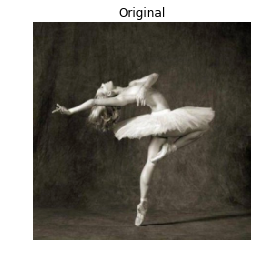

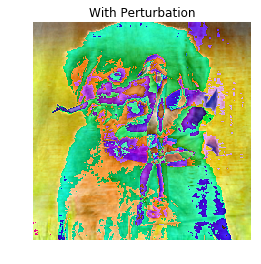

In [37]:
image_plus_perturbation("./dancing.jpg", perturbation)

### Let's sample 5 random classes, Corrupt the dog to each class to get perturbations P_1,...,P_10 and see if they all work

In [460]:
# Modularize Pipeline from above to get pertuebation for dog to target_class which is the index of the target class
def get_perturbation(target_class):
    y_target = Variable(torch.LongTensor([target_class]), requires_grad=False)

    # Max change per pixel
    epsilon = 1000
    # Max iterations
    num_steps = 100
    # Step size
    alpha = 0.25
    # Loss Fn
    loss = torch.nn.CrossEntropyLoss()
    # Starting image 
    image_start = load_image("./images/dog_1.jpg", (240,240))

    # This tensor stays fixed for reference point
    image_tensor = image_start.data

    for i in range(num_steps):
        # Fresh gradients
        zero_gradients(image_start)

        # Get CNN clasiffication and loss
        output = cnn.forward(image_start)
        loss_value = loss(output, y_target)

        # Backward call to get gradients
        loss_value.backward()

        # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
        grad = alpha * torch.sign(image_start.grad.data)

        # k pixels thick border
        k=10
        grad[:, :, k:-k, k:-k] = 0

        image_temp = image_start.data - grad
        total_grad = image_temp - image_tensor
        total_grad = torch.clamp(total_grad, -epsilon, epsilon)
        image_adversarial = image_tensor + total_grad
        image_start.data = image_adversarial
        
    print('Got Perturbation')
    return image_start.data - image_tensor

In [461]:
p_1 = get_perturbation(46) #Green_lizard
p_2 = get_perturbation(344) #Hippopotamus
p_3 = get_perturbation(603) #Horse_cart
p_4 = get_perturbation(776) #Sax
p_5 = get_perturbation(924) #Guac

Got Perturbation
Got Perturbation
Got Perturbation
Got Perturbation
Got Perturbation


In [462]:
print("Bird + Perturbation")
image_plus_perturbation("./images/bird.jpg", p_1, False)
image_plus_perturbation("./images/bird.jpg", p_2, False)
image_plus_perturbation("./images/bird.jpg", p_3, False)
image_plus_perturbation("./images/bird.jpg", p_4, False)
image_plus_perturbation("./images/bird.jpg", p_5, False)
print("\n", "Dance + Perturbation")
image_plus_perturbation("./images/dancing.jpg", p_1, False)
image_plus_perturbation("./images/dancing.jpg", p_2, False)
image_plus_perturbation("./images/dancing.jpg", p_3, False)
image_plus_perturbation("./images/dancing.jpg", p_4, False)
image_plus_perturbation("./images/dancing.jpg", p_5, False)
print("\n", "Bike + Perturbation")
image_plus_perturbation("./images/dog_3.jpg", p_1, False)
image_plus_perturbation("./images/dog_3.jpg", p_2, False)
image_plus_perturbation("./images/dog_3.jpg", p_3, False)
image_plus_perturbation("./images/dog_3.jpg", p_4, False)
image_plus_perturbation("./images/dog_3.jpg", p_5, False)

Bird + Perturbation
Original:
goose 37.99434304237366 %
After Perturbation:
green_lizard 99.99117851257324 %
Original:
goose 37.99434304237366 %
After Perturbation:
hippopotamus 99.9999463558197 %
Original:
goose 37.99434304237366 %
After Perturbation:
gondola 26.569178700447083 %
Original:
goose 37.99434304237366 %
After Perturbation:
sax 99.5568573474884 %
Original:
goose 37.99434304237366 %
After Perturbation:
guacamole 85.95181703567505 %

 Dance + Perturbation
Original:
American_egret 55.12174963951111 %
After Perturbation:
green_lizard 99.99999403953552 %
Original:
American_egret 55.12174963951111 %
After Perturbation:
hippopotamus 100.0 %
Original:
American_egret 55.12174963951111 %
After Perturbation:
horse_cart 84.50419902801514 %
Original:
American_egret 55.12174963951111 %
After Perturbation:
sax 99.99979138374329 %
Original:
American_egret 55.12174963951111 %
After Perturbation:
guacamole 99.99523162841797 %

 Bike + Perturbation
Original:
golden_retriever 96.53496146202087

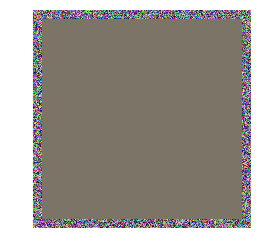

In [463]:
show_image(p_1)

### Random location of pixels, let's constrain number of pixels allowed to change

In [38]:
def get_n_random_pixel_locations(n):
    num_pixels_to_change = n
    points = []
    for i in range(num_pixels_to_change):
        points.append((np.random.randint(240), np.random.randint(240)))
    return points

def zero_grad_outside_of_allowed_points(grad, points):
    for row in range(240):
        for col in range(240):
            if not ((row, col) in points):
                grad[:, :, row, col] = torch.zeros(1,3)
    
    return grad


n_points = get_n_random_pixel_locations(800)

In [34]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([966]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 1000

# Max iterations
num_steps = 100

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting image 
image_start = load_image("./dog.jpg", (240,240))

# This tensor stays fixed for reference point
image_tensor = image_start.data

for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output = cnn.forward(image_start)
    loss_value = loss(output, y_target)
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad = alpha * torch.sign(image_start.grad.data)

    # Only change pixels outside of randomized set
    grad = zero_grad_outside_of_allowed_points(grad, n_points)
    
    image_temp = image_start.data - grad
    total_grad = image_temp - image_tensor
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    image_adversarial = image_tensor + total_grad
    image_start.data = image_adversarial
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


red_wine 99.99997615814209 %
goblet 4.353230309561695e-06 %
car_mirror 3.776233725716338e-06 %
strawberry 2.6249768581010358e-06 %
wine_bottle 2.300554946543798e-06 %
bubble 1.5548025089628936e-06 %
hip 1.4723045005382573e-06 %
trifle 1.2400175997129281e-06 %
paintbrush 9.595702010756213e-07 %
beer_glass 9.453693827765619e-07 %


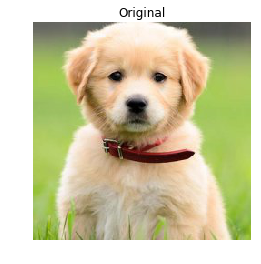

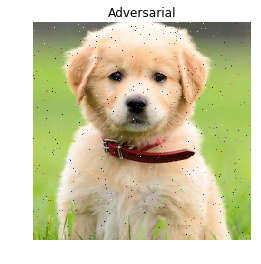

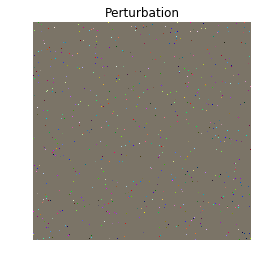

In [36]:
top_k(cnn(image_start))

show_image(image_tensor, title='Original')
show_image(image_start, title='Adversarial')
show_image(image_start.data - image_tensor, title='Perturbation')

Original:
goose 37.99434304237366 %
After Perturbation:
shower_curtain 92.11543202400208 %
Original:
American_egret 55.12174963951111 %
After Perturbation:
bubble 95.31310796737671 %
Original:
bicycle-built-for-two 89.08305764198303 %
After Perturbation:
bicycle-built-for-two 69.30918097496033 %


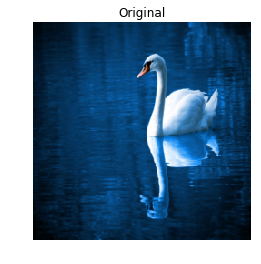

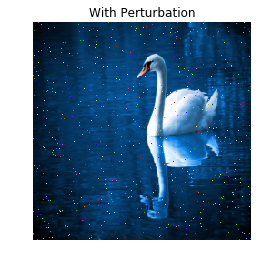

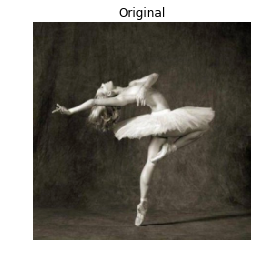

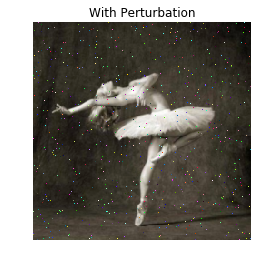

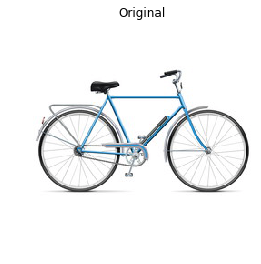

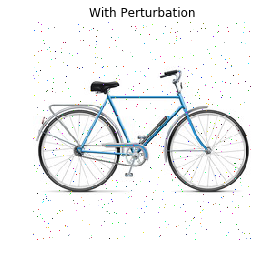

In [37]:
perturbation = image_start.data - image_tensor
image_plus_perturbation("./bird.jpg", perturbation)
image_plus_perturbation("./dancing.jpg", perturbation)
image_plus_perturbation("./bike.jpg", perturbation)

### Approach above did not generalize, let's try minimizing expected loss across images

In [21]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([966]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 1000

# Max iterations
num_steps = 100

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting images
image_start_1 = load_image("./dog.jpg", (240,240))
image_start_2 = load_image("./dancing.jpg", (240,240))
image_start_3 = load_image("./bike.jpg", (240,240))

# These tensors stay fixed for reference points
image_tensor_1 = image_start_1.data
image_tensor_2 = image_start_2.data
image_tensor_3 = image_start_3.data


for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output_1 = cnn.forward(image_start_1)
    output_2 = cnn.forward(image_start_2)
    output_3 = cnn.forward(image_start_3)
    
    loss_value = loss(output_1, y_target) + loss(output_2, y_target) + loss(output_3, y_target) 
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad_1 = alpha * torch.sign(image_start_1.grad.data)
    grad_2 = alpha * torch.sign(image_start_2.grad.data)
    grad_3 = alpha * torch.sign(image_start_3.grad.data)
    
    # Only change pixels outside of randomized set
    grad_1 = zero_grad_outside_of_allowed_points(grad_1, n_points)
    grad_2 = zero_grad_outside_of_allowed_points(grad_2, n_points)
    grad_3 = zero_grad_outside_of_allowed_points(grad_3, n_points)
    
    # Need to clamp
    image_temp_1 = image_start_1.data - grad_1
    image_temp_2 = image_start_2.data - grad_2
    image_temp_3 = image_start_3.data - grad_3
    
    total_grad_1 = image_temp_1 - image_tensor_1
    total_grad_2 = image_temp_2 - image_tensor_2
    total_grad_3 = image_temp_3 - image_tensor_3
    
    
    total_grad_1 = torch.clamp(total_grad_1, -epsilon, epsilon)
    total_grad_2 = torch.clamp(total_grad_2, -epsilon, epsilon)
    total_grad_3 = torch.clamp(total_grad_3, -epsilon, epsilon)
    
    average_grad = (total_grad_1 + total_grad_2 + total_grad_3)/3
    
    image_start_1.data = image_tensor_1 + average_grad
    image_start_2.data = image_tensor_2 + average_grad
    image_start_3.data = image_tensor_3 + average_grad
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


bubble 42.820462584495544 %
balloon 33.21644067764282 %
spotlight 8.848898857831955 %
lampshade 7.026340067386627 %
fountain 1.8710950389504433 %
shower_curtain 1.4715345576405525 %
red_wine 0.8656547404825687 %
candle 0.7769461255520582 %
spider_web 0.617717020213604 %
groom 0.45767962001264095 %


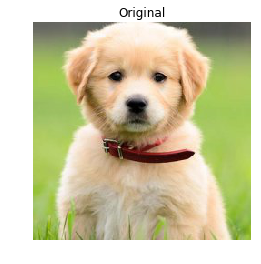

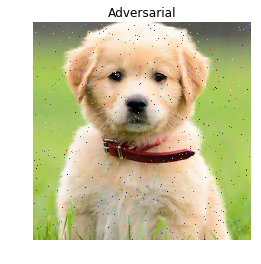

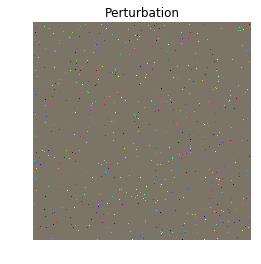

In [24]:
top_k(cnn(image_start_1))

show_image(image_tensor_1, title='Original')
show_image(image_start_1, title='Adversarial')
show_image(image_start_1.data - image_tensor, title='Perturbation')

Original:
goose 37.99434304237366 %
After Perturbation:
shower_curtain 98.71784448623657 %
Original:
American_egret 55.12174963951111 %
After Perturbation:
bubble 53.878384828567505 %
Original:
bicycle-built-for-two 89.08305764198303 %
After Perturbation:
bubble 33.68956446647644 %


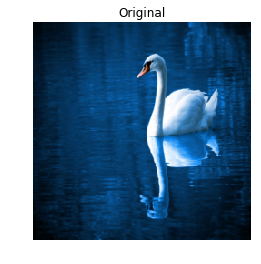

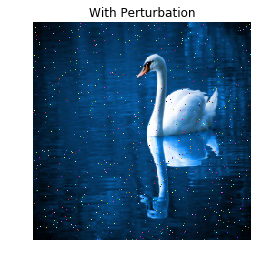

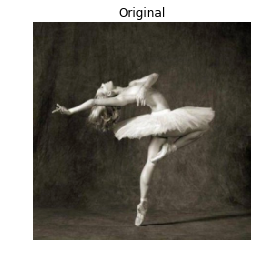

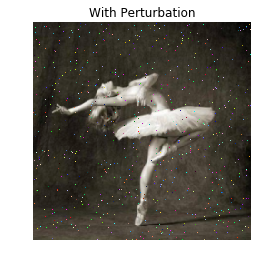

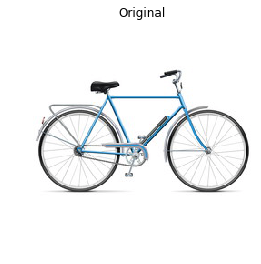

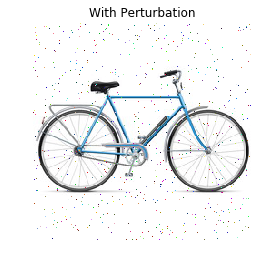

In [25]:
perturbation = image_start_1.data - image_tensor_1
image_plus_perturbation("./bird.jpg", perturbation)
image_plus_perturbation("./dancing.jpg", perturbation)
image_plus_perturbation("./bike.jpg", perturbation)

Some pictures unseen during training:
Original:
screw 98.41756820678711 %
After Perturbation:
bubble 96.8731939792633 %
Original:
bagel 46.029168367385864 %
After Perturbation:
bubble 95.31418085098267 %


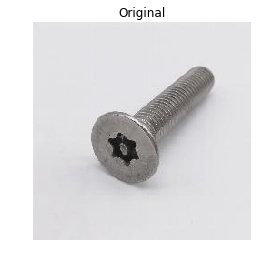

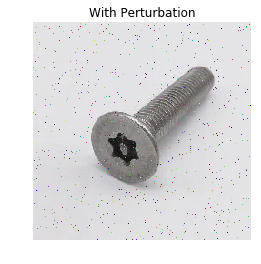

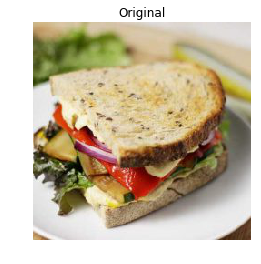

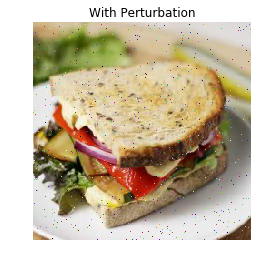

In [26]:
print('Some pictures unseen during training:')
image_plus_perturbation("./screw.jpg", perturbation)
image_plus_perturbation("./food.jpg", perturbation)

### Different Target Class

In [29]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([137]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 1000

# Max iterations
num_steps = 100

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting images
image_start_1 = load_image("./dog.jpg", (240,240))
image_start_2 = load_image("./dancing.jpg", (240,240))
image_start_3 = load_image("./bike.jpg", (240,240))

# These tensors stay fixed for reference points
image_tensor_1 = image_start_1.data
image_tensor_2 = image_start_2.data
image_tensor_3 = image_start_3.data


for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output_1 = cnn.forward(image_start_1)
    output_2 = cnn.forward(image_start_2)
    output_3 = cnn.forward(image_start_3)
    
    loss_value = loss(output_1, y_target) + loss(output_2, y_target) + loss(output_3, y_target) 
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad_1 = alpha * torch.sign(image_start_1.grad.data)
    grad_2 = alpha * torch.sign(image_start_2.grad.data)
    grad_3 = alpha * torch.sign(image_start_3.grad.data)
    
    # Only change pixels outside of randomized set
    grad_1 = zero_grad_outside_of_allowed_points(grad_1, n_points)
    grad_2 = zero_grad_outside_of_allowed_points(grad_2, n_points)
    grad_3 = zero_grad_outside_of_allowed_points(grad_3, n_points)
    
    # Need to clamp
    image_temp_1 = image_start_1.data - grad_1
    image_temp_2 = image_start_2.data - grad_2
    image_temp_3 = image_start_3.data - grad_3
    
    total_grad_1 = image_temp_1 - image_tensor_1
    total_grad_2 = image_temp_2 - image_tensor_2
    total_grad_3 = image_temp_3 - image_tensor_3
    
    
    total_grad_1 = torch.clamp(total_grad_1, -epsilon, epsilon)
    total_grad_2 = torch.clamp(total_grad_2, -epsilon, epsilon)
    total_grad_3 = torch.clamp(total_grad_3, -epsilon, epsilon)
    
    average_grad = (total_grad_1 + total_grad_2 + total_grad_3)/3
    
    image_start_1.data = image_tensor_1 + average_grad
    image_start_2.data = image_tensor_2 + average_grad
    image_start_3.data = image_tensor_3 + average_grad
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


Original:
goose 37.99434304237366 %
After Perturbation:
pitcher 20.779310166835785 %
Original:
American_egret 55.12174963951111 %
After Perturbation:
fountain 14.210930466651917 %
Original:
bicycle-built-for-two 89.08305764198303 %
After Perturbation:
bicycle-built-for-two 46.49848937988281 %
Some pictures unseen during training:
Original:
screw 98.41756820678711 %
After Perturbation:
screw 92.20165610313416 %
Original:
bagel 46.029168367385864 %
After Perturbation:
plate 37.1885746717453 %


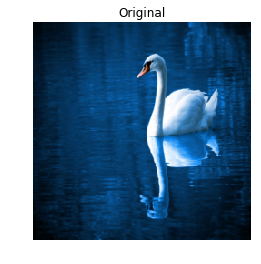

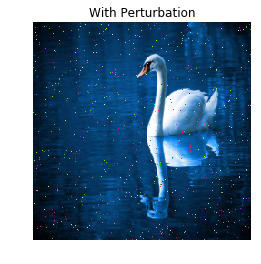

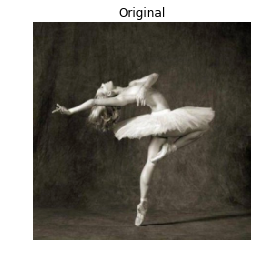

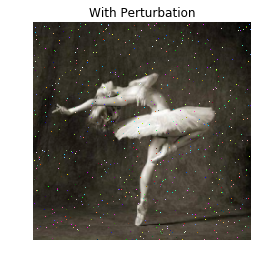

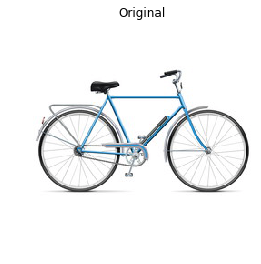

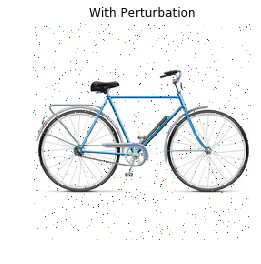

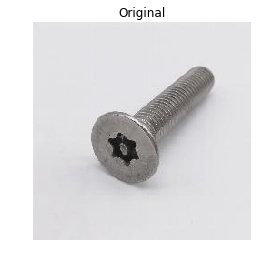

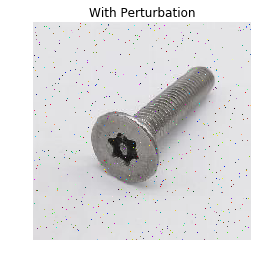

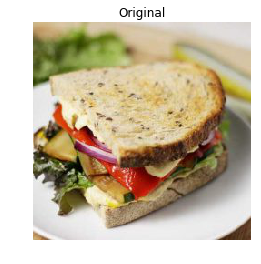

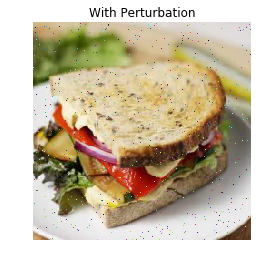

In [28]:
perturbation = image_start_1.data - image_tensor_1
image_plus_perturbation("./bird.jpg", perturbation)
image_plus_perturbation("./dancing.jpg", perturbation)
image_plus_perturbation("./bike.jpg", perturbation)

print('Some pictures unseen during training:')
image_plus_perturbation("./screw.jpg", perturbation)
image_plus_perturbation("./food.jpg", perturbation)

### Let's see if we can get a uniform filter that pushes any class to a certain target class

In [66]:
def uniformize_grad(grad):
    total_pixels = 240*240
    mean_R = torch.sum(grad[:,0])/total_pixels
    mean_B = torch.sum(grad[:,1])/total_pixels
    mean_G = torch.sum(grad[:,2])/total_pixels
    
    grad_R = torch.FloatTensor(np.full((240, 240), mean_R))
    grad_B = torch.FloatTensor(np.full((240, 240), mean_B))
    grad_G = torch.FloatTensor(np.full((240, 240), mean_G))
    
    return torch.stack([grad_R, grad_B, grad_G], 0).unsqueeze(0)

In [93]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([924]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 1000

# Max iterations
num_steps = 100

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting image 
image_start = load_image("./dog.jpg", (240,240))

# This tensor stays fixed for reference point
image_tensor = image_start.data

for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output = cnn.forward(image_start)
    loss_value = loss(output, y_target)
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad = alpha * torch.sign(image_start.grad.data)
    grad = uniformize_grad(grad)
    
    image_temp = image_start.data - grad
    total_grad = image_temp - image_tensor
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    
    image_adversarial = image_tensor + total_grad
    image_start.data = image_adversarial
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [103]:
top_k(cnn(image_start))

# show_image(image_tensor, title='Original')
# show_image(image_start, title='Adversarial')
# show_image(image_start.data - image_tensor, title='Perturbation')

golden_retriever 44.67116594314575 %
red_wine 4.326852411031723 %
Brittany_spaniel 3.9988305419683456 %
Border_collie 3.026624582707882 %
clumber 2.806769870221615 %
soccer_ball 2.6008332148194313 %
kuvasz 2.4471336975693703 %
sunglasses 2.106505259871483 %
Labrador_retriever 2.078148163855076 %
tennis_ball 1.8782319501042366 %


In [92]:
torch.sum(grad[:,1] > 0.0001)

tensor(57600)

### Border with same perturbations along columns and rows

In [42]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
y_target = Variable(torch.LongTensor([966]), requires_grad=False) #924= guac

# Max change per pixel
epsilon = 1000

# Max iterations
num_steps = 5

# Step size
alpha = 0.25

# Loss Fn
loss = torch.nn.CrossEntropyLoss()

# Starting image 
image_start = load_image("./dog.jpg", (240,240))

# This tensor stays fixed for reference point
image_tensor = image_start.data

for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output = cnn.forward(image_start)
    loss_value = loss(output, y_target)
    
    # Backward call to get gradients
    loss_value.backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad = alpha * torch.sign(image_start.grad.data)

    # k pixels thick border
    k=1
    grad[:, :, :, :119] = 0
    grad[:, :, :, 122:] = 0
    
    
    image_temp = image_start.data - grad
    total_grad = image_temp - image_tensor
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    image_adversarial = image_tensor + total_grad
    image_start.data = image_adversarial
    
    print(i)

0
1
2
3
4


golden_retriever 65.73173403739929 %
Labrador_retriever 7.915572822093964 %
Brittany_spaniel 5.613308027386665 %
clumber 3.0382219702005386 %
Border_collie 2.1136485040187836 %
soccer_ball 2.0651347935199738 %
tennis_ball 1.3725006021559238 %
Sussex_spaniel 1.0247590951621532 %
kuvasz 0.9106841869652271 %
Great_Pyrenees 0.7967683486640453 %


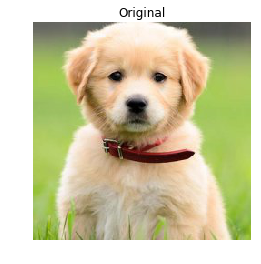

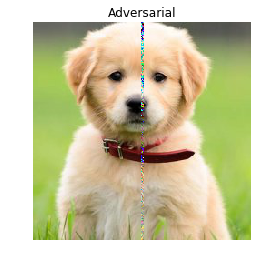

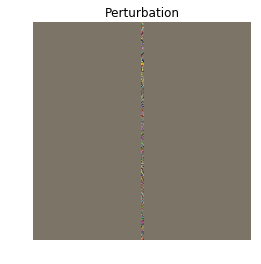

In [43]:
top_k(cnn(image_start))

show_image(image_tensor, title='Original')
show_image(image_start, title='Adversarial')
show_image(image_start.data - image_tensor, title='Perturbation')

perturbation = image_start.data - image_tensor

American_egret 52.025991678237915 %
goose 14.138805866241455 %
crane 11.895275115966797 %
lakeside 7.612358778715134 %
black_swan 1.7780149355530739 %
little_blue_heron 1.7309438437223434 %
flamingo 1.4360117726027966 %
plastic_bag 0.6521169561892748 %
spoonbill 0.5650947336107492 %
umbrella 0.3277880372479558 %


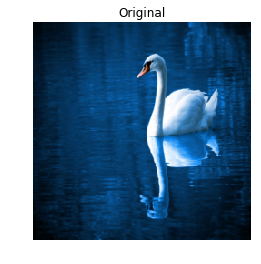

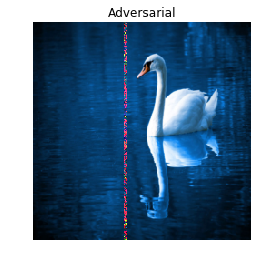

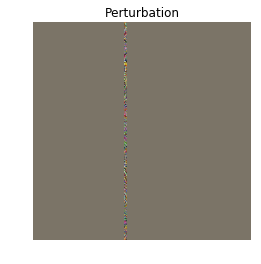

In [44]:
perturbation = image_start.data - image_tensor

image_tensor = load_image("./bird.jpg", (240,240)).data

img_shf = image_tensor.clone()
img_shf[:,:,:,100:103] += perturbation[:,:,:,119:122]

top_k(cnn(img_shf))

show_image(image_tensor, title='Original')
show_image(img_shf, title='Adversarial')
show_image(img_shf.data - image_tensor, title='Perturbation')

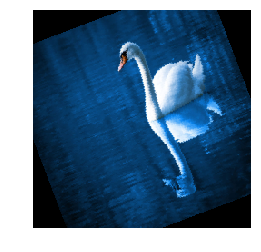

In [45]:
src_im = Image.open("./bird.jpg")

loader = transforms.Compose([
    transforms.Resize((240,240)),  
    transforms.RandomRotation((-30,30), resample=False, expand=False, center=None),
    transforms.ToTensor()
])

loaded = loader(src_im)

unloader = transforms.ToPILImage()
image_final = unloader(loaded)

plt.figure()
plt.axis('off')
plt.imshow(image_final)

In [225]:
# Given a perturbation tensor (all zeros except for perturbation indices), and a gradient tensor, 
# should zero out the gradient outside of the perturbation pixels
# Perturbation can be any shape
def zero_out_grad_beyond_perturbation(grad, pert):
    # Which pixels are perturbed?
    shape = pert != 0
    zeroed_grad = torch.mul(shape.float(), grad)
    return zeroed_grad

In [292]:
y_target = Variable(torch.LongTensor([966]), requires_grad=False) #924= guac
epsilon = 1000
num_steps_per_iterations = 5
num_iterations = 100
alpha = 0.25
loss = torch.nn.CrossEntropyLoss()

prob_switch_image = 0.50
images = ["./images/dog_1.jpg", "./images/bike.jpg", "./images/bird.jpg", "./images/dancing.jpg"]

image_start = load_image("./images/dog_1.jpg", (240,240))
image_tensor = image_start.data
first_image = True

for k in range(num_iterations):
    
    # Switch picture
    if (not first_image): 
        print('image switched')
        
        # Sample new image
        image_name = images[np.random.randint(len(images))]
        image_start = load_image(image_name, (240,240))
        
        # apply cumulated perturbation to image
        image_start.data += perturbation
        
        # Reference (unchanged)
        image_tensor = image_start.data

        
    for i in range(num_steps_per_iterations):
        # Fresh gradients
        zero_gradients(image_start)

        # Get CNN clasiffication and loss
        output = cnn.forward(image_start)
        if i==num_steps_per_iterations-1: top_k(output, 1)
        
        loss_value = loss(output, y_target)

        # Backward call to get gradients
        loss_value.backward()

        # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
        grad = alpha * torch.sign(image_start.grad.data)
        
        image_temp = image_start.data - grad
        total_grad = image_temp - image_tensor
        total_grad = torch.clamp(total_grad, -epsilon, epsilon)
        
        # zero_out grad beyond perturbation strip
#         if (not first_image):
#             total_grad = zero_out_grad_beyond_perturbation(total_grad, perturbation)
        
        # if first image, make a vertical strip in the middle for the perturbation
#         if (first_image):
        total_grad[:, :, :, :115] = 0
        total_grad[:, :, :, 125:] = 0
        
        image_start.data = image_tensor + total_grad
        
    first_image = False
        
    # Translate and rotate perturbation
    perturbation = image_start.data - image_tensor
    
#     show_image(perturbation)
    
#     perturbation = probabilistic_affine_transform(perturbation)
    
    

Pembroke 71.7290461063385 %
image switched
red_wine 70.390784740448 %
image switched
Pembroke 16.02006107568741 %
image switched
necklace 18.274246156215668 %
image switched
red_wine 85.37598252296448 %
image switched
bicycle-built-for-two 12.056994438171387 %
image switched
red_wine 17.90446937084198 %
image switched
red_wine 51.149165630340576 %
image switched
red_wine 61.089521646499634 %
image switched
Ibizan_hound 7.554461807012558 %
image switched
red_wine 32.08339214324951 %
image switched
Cardigan 9.527585655450821 %
image switched
red_wine 45.26606798171997 %
image switched
red_wine 95.370614528656 %
image switched


KeyboardInterrupt: 

In [ ]:
prob = 0.25

# Bernoulli, returns 1=True with the input probability
def yes_with_prob(prob):
    random_float = np.random.random_sample()
    if random_float < prob:
        return True
    return False

yes_with_prob(0.25)


# Rotate and translate a perturbation tensor
def probabilistic_affine_transform(perturbation_tens):
    
    perturbation_tensor = perturbation_tens.clone()
    perturbation_tensor.squeeze(0)
    
    unloader = transforms.ToPILImage()
    perturbation_image = unloader(perturbation_tensor.squeeze(0))
    
    transformer = transforms.Compose([
        transforms.RandomAffine((0,15), translate=(0,0)),
        transforms.ToTensor()
    ])
    
    perturbation_tensor = transformer(perturbation_image)
    
    return perturbation_tensor

In [161]:
np.random.randint(5)

1

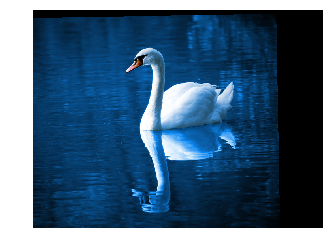

In [177]:

image_final = unloader(image_start)
    
plt.figure()
plt.axis('off')
plt.imshow(image_final)


plate 54.00593876838684 %
French_loaf 20.099300146102905 %
bagel 11.301382631063461 %
potpie 2.6855608448386192 %
eggnog 2.0224424079060555 %
strawberry 1.4630579389631748 %
guacamole 1.2538125738501549 %
meat_loaf 1.2374135665595531 %
ice_cream 0.7740649860352278 %
trifle 0.5831514950841665 %


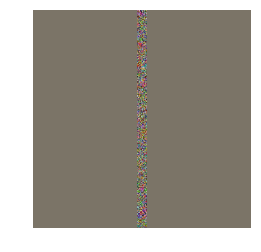

In [293]:
show_image(perturbation)

image = load_image("./images/food.jpg", (240,240))
image_tensor = image.data

top_k(cnn(image_tensor + perturbation))

In [269]:
dog = load_image("./images/dog_1.jpg", (240,240)).data #263
bird = load_image("./images/bird.jpg", (240,240)).data #99
bike = load_image("./images/bike.jpg", (240,240)).data #444
food = load_image("./images/food.jpg", (240,240)).data #931
dancing = load_image("./images/dancing.jpg", (240,240)).data #132
top_k(cnn(dog),1) 
top_k(cnn(bird),1)
top_k(cnn(bike),1)
top_k(cnn(food),1)
top_k(cnn(dancing),1)

Pembroke 83.13344717025757 %
goose 37.99434304237366 %
bicycle-built-for-two 89.08305764198303 %
bagel 46.029168367385864 %
American_egret 55.12174963951111 %


In [291]:
epsilon = 0.01
num_steps_per_iterations = 10
num_iterations = 100
alpha = 0.25
loss = torch.nn.CrossEntropyLoss()

images = [("./images/dog_1.jpg", 263), ("./images/bike.jpg", 444), ("./images/bird.jpg", 99), ("./images/dancing.jpg", 132)]

image_start = load_image("./images/dog_1.jpg", (240,240))
image_tensor = image_start.data

perturbation = torch.zeros(1,3,240,240)

for k in range(num_iterations):
    
    # Switch picture
#     print('image switched: ', image[0])
#     image = images[np.random.randint(len(images))]
#     image_start = load_image(image[0], (240,240))
#     image_tensor = image_start.data
    y_target = Variable(torch.LongTensor([188]), requires_grad=False)
    
    # apply cumulated perturbation to image
    image_start.data += perturbation
    
    for i in range(num_steps_per_iterations):
        # Fresh gradients
        zero_gradients(image_start)

        # Get CNN clasiffication and loss
        output = cnn.forward(image_start)
        if i==num_steps_per_iterations-1: top_k(output, 1)
        
        loss_value = loss(output, y_target)

        # Backward call to get gradients
        loss_value.backward()

        # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
        grad = alpha * -torch.sign(image_start.grad.data)
        
        image_temp = image_start.data - grad
        total_grad = image_temp - image_tensor
        total_grad = torch.clamp(total_grad, -epsilon, epsilon)
        image_start.data = image_tensor + total_grad
        
#     perturbation = image_start.data - image_tensor

Pembroke 97.33940362930298 %
Pembroke 97.48156666755676 %
Pembroke 97.1671462059021 %
Pembroke 96.4377760887146 %
Pembroke 96.26268744468689 %
Pembroke 96.28210663795471 %
Pembroke 96.59582376480103 %
Pembroke 96.29892706871033 %
Pembroke 96.37355208396912 %
Pembroke 96.3271975517273 %
Pembroke 96.09959721565247 %
Pembroke 96.55961394309998 %
Pembroke 95.8286464214325 %
Pembroke 96.36735916137695 %
Pembroke 96.63934707641602 %
Pembroke 96.34743928909302 %
Pembroke 97.0147967338562 %
Pembroke 96.10087871551514 %
Pembroke 96.68626189231873 %
Pembroke 96.34168148040771 %
Pembroke 96.83460593223572 %
Pembroke 96.16639018058777 %
Pembroke 96.50967121124268 %
Pembroke 95.94215154647827 %
Pembroke 95.99992632865906 %
Pembroke 96.70041799545288 %
Pembroke 96.6853141784668 %
Pembroke 96.48454785346985 %
Pembroke 96.3142991065979 %
Pembroke 97.13283777236938 %
Pembroke 96.97127342224121 %
Pembroke 96.19341492652893 %
Pembroke 96.30476236343384 %
Pembroke 96.75900936126709 %
Pembroke 96.532922983

In [271]:
torch.zeros(1,3,240,240).size()

torch.Size([1, 3, 240, 240])

In [288]:
for i in range(5):
    image = load_image("./images/cat_" + str(i+1) + ".jpg", (240,240)).data
    top_k(cnn(image + perturbation),1)

Egyptian_cat 79.49411869049072 %
Egyptian_cat 90.45154452323914 %
Egyptian_cat 30.25040626525879 %
Angora 14.871898293495178 %
tabby 21.750901639461517 %


In [283]:
image = load_image("./images/food.jpg", (240,240)).data
top_k(cnn(image + perturbation),1)

bagel 66.1543607711792 %


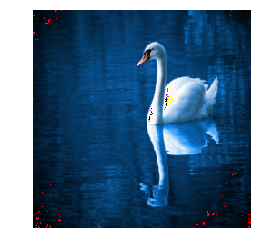

In [287]:
show_image(image_tensor+perturbation)

In [307]:
import os

    
    
# returns all image paths in the folder provided
def get_images(folderpath):
    files = os.listdir(folderpath)
    images = []
    
    for name in files:
        if(name[len(name)-3:]=='jpg'):
            images.append(folderpath + '/' + name)
    
    return images
            
images = get_images('./images')


# sample n images from all images for this batch
def sample_for_batch(images, n):
    images_batch = []
    indices = [np.random.randint(0,len(images)) for i in range(n)]
    images_batch = [images[j] for j in indices]
    return images_batch

sample_for_batch(images, 5)

['./images/cat_2.jpg',
 './images/dog_4.jpg',
 './images/white.jpg',
 './images/random.jpg',
 './images/cat_6.jpg']

Persian_cat 23.437930643558502 %
bow_tie 20.22724151611328 %
Egyptian_cat 46.0775762796402 %
Egyptian_cat 70.66982984542847 %
bow_tie 20.22724151611328 %
Persian_cat 23.437930643558502 %
bow_tie 20.22724151611328 %
bow_tie 20.22724151611328 %
Egyptian_cat 70.66982984542847 %
Egyptian_cat 46.0775762796402 %


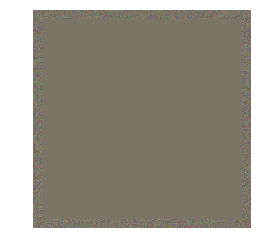

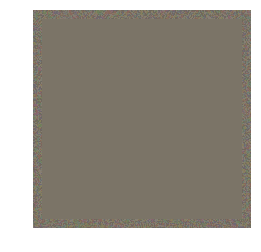

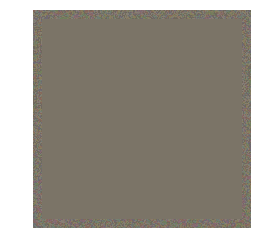

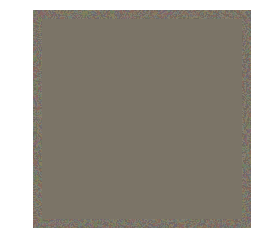

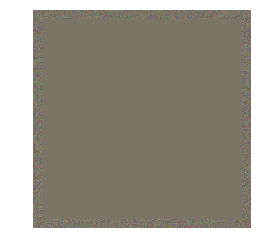

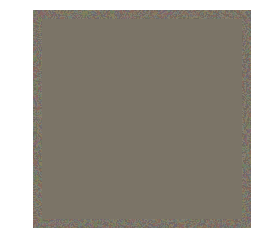

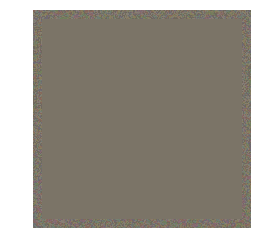

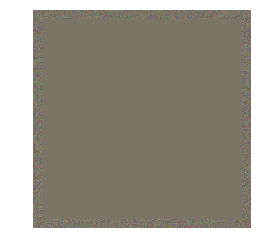

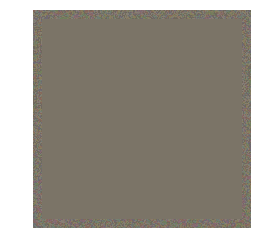

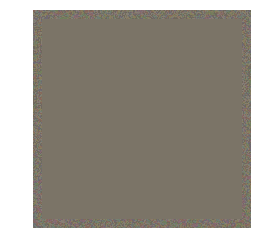

In [398]:
y_target = Variable(torch.LongTensor([153]), requires_grad=False) #924= guac
epsilon = 0.2
num_steps_per_iterations = 5
num_iterations = 10
alpha = 0.25
loss = torch.nn.CrossEntropyLoss()

image_dir = './cat_train'
images = get_images(image_dir)
num_per_batch = 5

# Initially no perturb
perturbation = torch.zeros(num_per_batch, 3, 240, 240)

for k in range(num_iterations):
#     alpha *= 1/num_iterations
    
    # New batch of variables
    images_batch = sample_for_batch(images, num_per_batch)
    variables_batch = Variable(torch.stack([load_image(image_name, (240,240)) for image_name in images_batch]).squeeze(1), requires_grad = True)
    assert(variables_batch.size() == torch.Size([num_per_batch, 3, 240, 240]))
    tensors_batch = variables_batch.data
    
    # Apply cumulated perturbation to images
    perturbation_batch = perturbation.expand(num_per_batch, 3, 240, 240)
    assert(perturbation_batch.size() == torch.Size([num_per_batch, 3, 240, 240]))
    variables_batch.data += perturbation_batch
    assert(variables_batch.size() == torch.Size([num_per_batch, 3, 240, 240]))
        
    for i in range(num_steps_per_iterations):
        # Fresh gradients
        zero_gradients(variables_batch)

        # Get CNN clasiffication and loss
        output = cnn.forward(variables_batch)
        
        # Print one of the classifications from batch for reality check
        if i==num_steps_per_iterations-1: top_k(output, 1)
        
        # Loss and backprop
        loss_batch = loss(output, y_target.expand(num_per_batch))
        loss_batch.backward()

        # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
        grad = alpha * torch.sign(variables_batch.grad.data)
        image_temp = variables_batch.data - grad
        total_grad = image_temp - tensors_batch
        total_grad = torch.clamp(total_grad, -epsilon, epsilon)
        
       # Make a vertical strip in the middle for the perturbation
#         dist_apart = 50
#         w = 20
#         for c in range(int(240/dist_apart)+1):
#             total_grad[:, :, (c*dist_apart)+w:((c+1)*dist_apart), :] = 0

        total_grad[:,:,10:-10,10:-10] = 0
        
        variables_batch.data = tensors_batch + total_grad
        
        # Average out perturbation and again expand to num_per_batch
        net_perturbation = variables_batch.data - tensors_batch
#         mean_perturbation = net_perturbation.mean(0)
        mean_perturbation = net_perturbation[np.random.randint(0,num_per_batch)]
        assert(mean_perturbation.size() == torch.Size([3, 240, 240]))
        perturbation_batch = mean_perturbation.expand(num_per_batch, 3, 240, 240)
        assert(perturbation_batch.size() == torch.Size([num_per_batch, 3, 240, 240]))
        
    show_image(perturbation_batch[0])

In [340]:
a = Variable(torch.zeros(10,100))
a.mean(0).size()

torch.Size([100])

vizsla 84.28605198860168 %


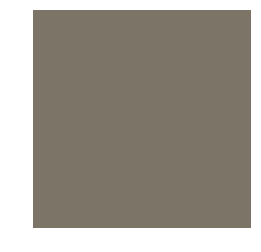

In [385]:
perturbation = perturbation_batch[0]
show_image(perturbation)
image = load_image("./images/dog_5.jpg", (240,240)).data
top_k(cnn(image + perturbation),1)

In [404]:
f_cnn = models.vgg19(pretrained=True).features.eval()
c_cnn = models.vgg19(pretrained=True).classifier.eval()
f_cnn.forward(image_start)

tensor([[[[  0.0000,   0.0000,   0.0000,  ...,   0.8580,   0.0000,
             0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   6.7132,   1.4440,
             0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.2458,
             0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,
             0.0000]],

         [[  0.0000,   0.1817,   0.0000,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.0000,   1.9161,   3.9451,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.0000,   0.0000,   1.2925,  ...,   0.0000,   0.0000,
             0.0000],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,
             0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,
           

In [453]:
# Choose target class through its index (Refer to JSON file for desired class to index mapping)
image_target = load_image("./images/dog_1.jpg", (240,240))
target = f_cnn(image_target).data

# Max change per pixel
epsilon = 0.3

# Max iterations
num_steps = 500

# Step size
alpha = 0.25

# Starting image 
image_start = load_image("./cat_train/cat_3.jpg", (240,240))

# This tensor stays fixed for reference point
image_tensor = image_start.data

for i in range(num_steps):
    # Fresh gradients
    zero_gradients(image_start)
    
    # Get CNN clasiffication and loss
    output = f_cnn.forward(image_start)
    loss_value = F.cosine_similarity(target, output)
    
    # Backward call to get gradients
    torch.sum(loss_value).backward()
    
    # Edit pixels by less than epsilon amount in direction opposite to gradient with step size alpha
    grad = alpha * torch.sign(image_start.grad.data)

    # k pixels thick border
#     k=10
#     grad[:, :, k:-k, k:-k] = 0
    
    image_temp = image_start.data - grad
    total_grad = image_temp - image_tensor
    total_grad = torch.clamp(total_grad, -epsilon, epsilon)
    image_adversarial = image_tensor + total_grad
    image_start.data = image_adversarial
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [454]:
top_k(cnn(image_start), 10)

vase 8.277076482772827 %
carton 7.641393691301346 %
tabby 4.567847773432732 %
plastic_bag 3.652013838291168 %
candle 3.129507228732109 %
purse 2.622370421886444 %
backpack 2.615821175277233 %
goblet 2.1313579753041267 %
lampshade 2.092730812728405 %
pitcher 1.9024869427084923 %


Original:
Egyptian_cat 34.12944972515106 %
After Perturbation:
vase 8.277076482772827 %
Egyptian_cat 46.269986033439636 %
tabby 30.958646535873413 %
tiger_cat 15.693673491477966 %
lynx 4.56366203725338 %
window_screen 0.18228736007586122 %
grey_fox 0.1725118956528604 %
Siamese_cat 0.13460402842611074 %
doormat 0.12836535461246967 %
kit_fox 0.11401411611586809 %
cougar 0.0905513297766447 %


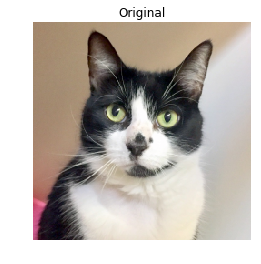

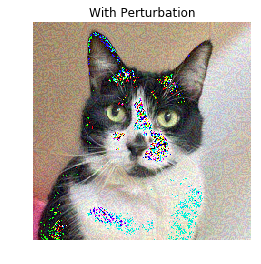

In [456]:
perturbation = image_start - image_tensor
image_plus_perturbation('./cat_train/cat_3.jpg', perturbation, draw=True)
top_k(cnn(perturbation + load_image('./cat_train/cat_2.jpg', (240,240))), 10)

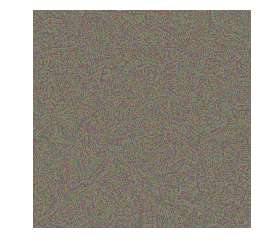

In [457]:
show_image(perturbation)